In [1]:
from intake import open_catalog

import numpy as np
import pandas as pd
import xarray as xr
import dask
import dask.array as da
import matplotlib.pyplot as plt
import intake
import os
import gcsfs

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andrewbrettin/Documents/google_cloud/brilliant-tower-277121-0fa8e100ef67.json"

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml")
list(cat)

['GFDL_CM2_6_control_ocean',
 'GFDL_CM2_6_control_ocean_surface',
 'GFDL_CM2_6_control_ocean_3D',
 'GFDL_CM2_6_control_ocean_transport',
 'GFDL_CM2_6_control_ocean_boundary_flux',
 'GFDL_CM2_6_control_ocean_budgets',
 'GFDL_CM2_6_one_percent_ocean',
 'GFDL_CM2_6_one_percent_ocean_surface',
 'GFDL_CM2_6_one_percent_ocean_3D',
 'GFDL_CM2_6_one_percent_ocean_transport',
 'GFDL_CM2_6_one_percent_ocean_boundary_flux',
 'GFDL_CM2_6_one_percent_ocean_budgets',
 'GFDL_CM2_6_grid']

In [3]:
ocean_dataset = cat['GFDL_CM2_6_control_ocean'].get().to_dask()
ocean_surface_dataset = cat['GFDL_CM2_6_control_ocean_surface'].get().to_dask()

/Users/andrewbrettin/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
print('Ocean dataset variables:')
for variable in ocean_dataset:
    print(variable, ':\t', ocean_dataset[variable].long_name)

print('\nOcean surface dataset variables:')
for variable in ocean_surface_dataset:
    print(variable, ':\t', ocean_surface_dataset[variable].long_name)

Ocean dataset variables:
average_DT :	 Length of average period
average_T1 :	 Start time for average period
average_T2 :	 End time for average period
eta_t :	 surface height on T cells [Boussinesq (volume conserving) model]
eta_u :	 surface height on U cells
frazil_2d :	 ocn frazil heat flux over time step
hblt :	 T-cell boundary layer depth from KPP
ice_calving :	 mass flux of land ice calving into ocean
mld :	 mixed layer depth determined by density criteria
mld_dtheta :	 mixed layer depth determined by temperature criteria
net_sfc_heating :	 surface ocean heat flux coming through coupler and mass transfer
pme_river :	 mass flux of precip-evap+river via sbc (liquid, frozen, evaporation)
pot_rho_0 :	 potential density referenced to 0 dbar
river :	 mass flux of river (runoff + calving) entering ocean
salt :	 Practical Salinity
salt_int_rhodz :	 vertical sum of Practical Salinity * rho_dzt
sea_level :	 effective sea level (eta_t + patm/(rho0*g)) on T cells
sea_levelsq :	 square of effec

AttributeError: 'DataArray' object has no attribute 'long_name'

In [10]:
ocean_dataset['u']

<xarray.DataArray 'u' (time: 240, st_ocean: 50, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<zarr, shape=(240, 50, 2700, 3600), dtype=float32, chunksize=(1, 5, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    cell_methods:   time: mean
    long_name:      i-current
    standard_name:  sea_water_x_velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-10.0, 10.0]

In [7]:
ocean_surface_dataset['sea_level']

,Array,Chunk
Bytes,284.02 GB,38.88 MB
Shape,"(7305, 2700, 3600)","(1, 2700, 3600)"
Count,7306 Tasks,7305 Chunks
Type,float32,numpy.ndarray


Looks like tau_x and tau_y is what we're looking for.  

Let's just do a sanity check to make sure that this is essentially the same dataset

In [5]:
sl1 = ocean_dataset['sea_level']
sl1

<xarray.DataArray 'sea_level' (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<zarr, shape=(240, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    cell_methods:   time: mean
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    standard_name:  sea_surface_height_above_geoid
    time_avg_info:  average_T1,average_T2,average_DT
    units:          meter
    valid_range:    [-1000.0, 1000.0]

In [6]:
sl2 = ocean_surface_dataset['sea_level']
sl2

,Array,Chunk
Bytes,284.02 GB,38.88 MB
Shape,"(7305, 2700, 3600)","(1, 2700, 3600)"
Count,7306 Tasks,7305 Chunks
Type,float32,numpy.ndarray


Looks like `ocean_dataset` only contains monthly averages, whereas `ocean_surface_dataset` contains daily averages. Furthermore, 

In [88]:
# Focus on wind shear
tau = np.sqrt(ocean_dataset['tau_x']**2 + ocean_dataset['tau_y']**2)
tau

<xarray.DataArray (time: 240, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<sqrt, shape=(240, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0

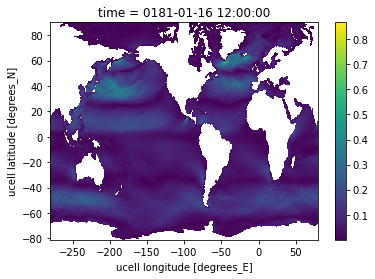

In [89]:
tau.isel(time=0).plot()

## CM 2.6 1pct increase CO2 experiments

In [5]:
co2_ocean_surface = cat['GFDL_CM2_6_one_percent_ocean_surface'].get().to_dask()

In [6]:
sea_level = co2_ocean_surface['sea_level']
sea_level

,Array,Chunk
Bytes,284.02 GB,38.88 MB
Shape,"(7305, 2700, 3600)","(1, 2700, 3600)"
Count,7306 Tasks,7305 Chunks
Type,float32,numpy.ndarray


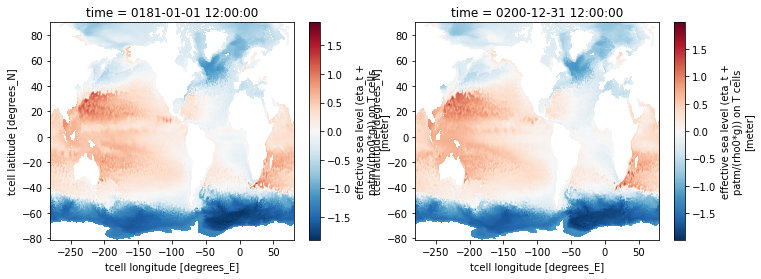

In [15]:
# Parse for which data is available
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
sea_level.isel(time=0).plot(ax=ax[0])
sea_level.isel(time=-1).plot(ax=ax[1])

In [11]:
# Load bathymetry data
bath_data = xr.open_dataset('~/Research/data/bathymetry.nc')
xt_coastal = np.load('/Users/andrewbrettin/Research/data/xt_coastal.npy')
yt_coastal = np.load('/Users/andrewbrettin/Research/data/yt_coastal.npy')

# New york timeseries
nyc_coords = (40.7128, -74.0060)
timeseries = sea_level.sel(yt_ocean = nyc_coords[0], xt_ocean=nyc_coords[1], method='nearest')
timeseries

,Array,Chunk
Bytes,29.22 kB,4 B
Shape,"(7305,)","(1,)"
Count,14611 Tasks,7305 Chunks
Type,float32,numpy.ndarray


## Mean ocean surface currents

In [6]:
speed = xr.ufuncs.sqrt(ocean_dataset['u']**2 + ocean_dataset['v']**2)
u_surf = speed.isel(st_ocean=0)

## Replicate plot from Delworth et al 2012
u_surf  = u_surf.sel(xu_ocean=slice(-100,-60), yu_ocean=slice(10,45))
u_surf

<xarray.DataArray (time: 240, yu_ocean: 404, xu_ocean: 400)>
dask.array<getitem, shape=(240, 404, 400), dtype=float32, chunksize=(1, 404, 400), chunktype=numpy.ndarray>
Coordinates:
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(404, 400), meta=np.ndarray>
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(404, 400), meta=np.ndarray>
    st_ocean  float64 5.034
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -99.9 -99.8 -99.7 -99.6 ... -60.2 -60.1 -60.0
  * yu_ocean  (yu_ocean) float64 10.05 10.15 10.24 10.34 ... 44.79 44.86 44.93

[########################################] | 100% Completed | 33.9s


Text(0.5, 1.0, '')

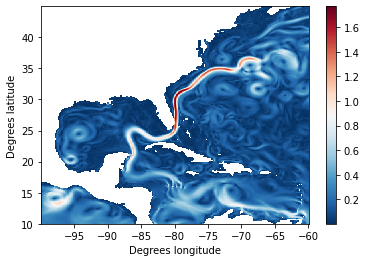

In [7]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    result = u_surf.isel(time=0).compute()

fig, ax = plt.subplots()
result.plot(ax=ax, cmap='RdBu_r')
ax.set_xlabel('Degrees longitude')
ax.set_ylabel('Degrees latitude')
ax.set_title('')

(10.0, 45.0)

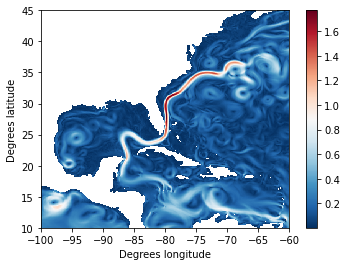

In [11]:
fig, ax = plt.subplots()
result.plot.pcolormesh(ax=ax, cmap='RdBu_r')
ax.set_xlabel('Degrees longitude')
ax.set_ylabel('Degrees latitude')
ax.set_title('')
ax.set_aspect('equal')
ax.set_xlim((-100, -60))
ax.set_ylim((10, 45))

In [13]:
fig.savefig('test.png')